In [1]:
#!ln -s /proyecto

# Memoria de Relevamiento

Se midieron con equipos GPS de simple frecuencia dos puntos que se denominaron
PFD1 y PFD2, y se vincularon a la estación permanente IGM1. En este apartado
se describe el procesamiento GPS, incluyendo la salida del programa de procesamiento. 

## Archivos de medición

Los archivos de medición se incluyen en formato Rinex 2.11, como

```
proyecto/PFD10240.20o
proyecto/PFD20240.20o
```

El archivo de medición de la estación IGM1 se obtuvo de la web del IGN, se incluye como

```
proyecto/igm10240.20o
```

## Datos de Sesion.

Los datos de la sesión, extraidos de los archivos de medición,
se completan en los anexos 4.1 que se adjuntan.

Se incluye también el anexo 4 con datos generales del trabajo.

In [2]:
FILEFLD = 'proyecto'
BASE = 'igm10240.20o'
PIE = 'PFD10240.20o'
AZIMUT = 'PFD20240.20o'

# Creación de Archivos de Sesiones

Se crean archivos para las dos sesiones de cada vector, Cortando los archivos 
con la herramienta RinEdit, del paquete GPSTk. Los tiempos se extraen también con
la herramienta RinSum, del paquete GPSTk

In [3]:
import fillforms
import os.path

In [4]:
import numbers
import pandas as pd
from math import cos
import re
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import pyconf

DEG2RAD = 3.14159 / 180

totime = lambda x: np.datetime64(datetime(*x))

In [5]:
rinex_info = []

for i in [BASE, PIE, AZIMUT]:
    archivo = os.path.join(FILEFLD,i)
    sumario = !RinSum {archivo}
    rinex_info.append((archivo,sumario))
# print('\n'.join(rinex_info))

In [6]:
rinex_times = []

for a,s in rinex_info:
    for i in s:
        if m := re.match(r'.*first\s+epoch:\s+(\d+).(\d+).(\d+).*?(\d+).(\d+).(\d+).*?=.*?(\d+)\s+(\d+)\s+([\d\.]+)',i):
            ini_time = totime((int(i) for i in m.groups()[:6]))
            ini_gpsw = int(m.groups()[6])
            ini_gpsdow = int(m.groups()[7])
            print('Epoca inicial: ',m.groups())
        if m := re.match(r'.*last\s+epoch:\s+(\d+).(\d+).(\d+).*?(\d+).(\d+).(\d+).*?=.*?(\d+)\s+(\d+)\s+([\d\.]+)',i):
            end_time = totime((int(i) for i in m.groups()[:6]))
            end_gpsw = int(m.groups()[6])
            end_gpsdow = int(m.groups()[7])
            print('Epoca final: ',m.groups())
            
    medio_st = '{},{},{},{},{},{}'.format(*(ini_time + (end_time-ini_time)/2).astype(datetime).timetuple())
    print('Epoca media: ',medio_st)
    rinex_times.append((a,ini_time,medio_st,end_time))

Epoca inicial:  ('2020', '01', '24', '18', '00', '00', '2089', '5', '496800.000')
Epoca final:  ('2020', '01', '25', '01', '59', '59', '2089', '6', '525599.000')
Epoca media:  2020,1,24,21,59,59
Epoca inicial:  ('2020', '01', '24', '18', '35', '15', '2089', '5', '498915.000')
Epoca final:  ('2020', '01', '24', '23', '48', '15', '2089', '5', '517695.000')
Epoca media:  2020,1,24,21,11,45
Epoca inicial:  ('2020', '01', '24', '19', '37', '31', '2089', '5', '502651.000')
Epoca final:  ('2020', '01', '25', '00', '21', '47', '2089', '6', '519707.000')
Epoca media:  2020,1,24,21,59,39


In [7]:
!mkdir -p {FILEFLD}/splits

splitfiles = []

for a,i,m,f in rinex_times:
    archivo = os.path.basename(a)
    archivo0 = archivo.replace('0.','1.') #HardCode
    archivo1 = archivo.replace('0.','2.') #HardCode
    !RinEdit --IF /{FILEFLD}/{archivo} --OF /{FILEFLD}/splits/{archivo0} --TE {m}
    !RinEdit --IF /{FILEFLD}/{archivo} --OF /{FILEFLD}/splits/{archivo1} --TB {m}
    
    splitfiles.append([archivo,archivo0])
    splitfiles.append([archivo,archivo1])

# RinEdit, part of the GPS Toolkit, Ver 2.4 9/23/15 rev, Run 2021/03/29 23:01:23
   End time --end is 2089,511199.000000 = 2020,1,24,21,59,59
Reading header...
# Header ObsIDs GAL (4): L1B C1B D1B S1B
# Header ObsIDs GPS (9): L1C L2W C1C C1W C2W D1C D2W S1C S2W
# Header ObsIDs GLO (9): L1C L2C C1C C1P C2P D1C D2C S1C S2C
# Header ObsIDs GEO (4): L1C C1C D1C S1C
Reading observations...
 Opened output file /proyecto/splits/igm10241.20o at time 2020/01/24 18:00:00 = 2089 496800.000 GPS
 Close output file.
RinEdit timing: processing 7.097 sec, wallclock: 7 sec.
# RinEdit, part of the GPS Toolkit, Ver 2.4 9/23/15 rev, Run 2021/03/29 23:01:30
   Begin time --begin is 2089,511199.000000 = 2020,1,24,21,59,59
Reading header...
# Header ObsIDs GAL (4): L1B C1B D1B S1B
# Header ObsIDs GPS (9): L1C L2W C1C C1W C2W D1C D2W S1C S2W
# Header ObsIDs GLO (9): L1C L2C C1C C1P C2P D1C D2C S1C S2C
# Header ObsIDs GEO (4): L1C C1C D1C S1C
Reading observations...
 Opened output file /proyecto/splits/igm1024

# Cómputo de PDOP

Con la herramienta PRSolve, parte de GPSTk, se calcula el PDOP para cada época de las sesiones, y 
se grafica a continuación (en un gráfico por cada sesión, incluyendo los datos de ambas estaciones).

Se calculó el PDOP máximo y medio en cada caso.

Output redirected to log file /proyecto/splits/igm10241.20o.sol
PRSolve timing: processing 16.912 sec, wallclock: 17 sec.


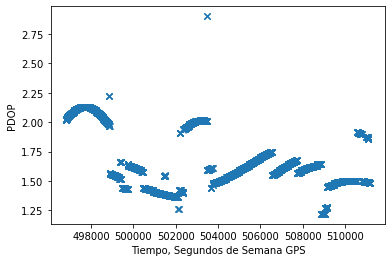

Max: 2.9, Min: 1.22, Promedio: 1.66
Output redirected to log file /proyecto/splits/igm10242.20o.sol
PRSolve timing: processing 17.609 sec, wallclock: 17 sec.


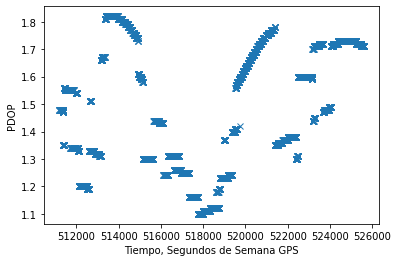

Max: 1.82, Min: 1.1, Promedio: 1.49
Output redirected to log file /proyecto/splits/PFD10241.20o.sol
PRSolve timing: processing 10.627 sec, wallclock: 11 sec.


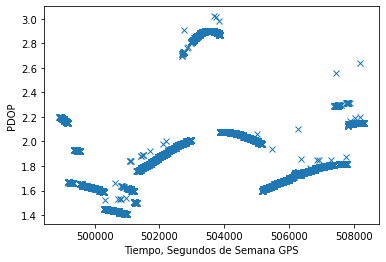

Max: 3.02, Min: 1.41, Promedio: 1.93
Output redirected to log file /proyecto/splits/PFD10242.20o.sol
PRSolve timing: processing 10.114 sec, wallclock: 10 sec.


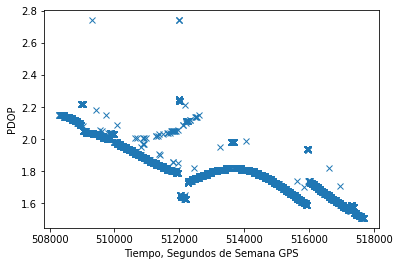

Max: 2.74, Min: 1.51, Promedio: 1.82
Output redirected to log file /proyecto/splits/PFD20241.20o.sol
PRSolve timing: processing 9.182 sec, wallclock: 9 sec.


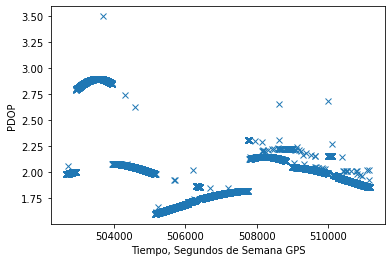

Max: 3.5, Min: 1.6, Promedio: 2.05
Output redirected to log file /proyecto/splits/PFD20242.20o.sol
PRSolve timing: processing 9.858 sec, wallclock: 10 sec.


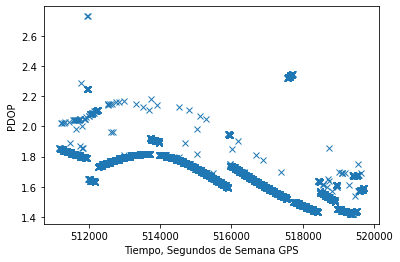

Max: 2.73, Min: 1.42, Promedio: 1.7


In [8]:
for b,i in splitfiles:
    nav = b[:-1]+'n'
    
    !PRSolve --obs /{FILEFLD}/splits/{i} --nav /{FILEFLD}/{nav} --sol GPS:1:C --log /{FILEFLD}/splits/{i}.sol
    !grep "RPF GPS:1:C RMS" /{FILEFLD}/splits/{i}.sol > /{FILEFLD}/splits/{i}.sol.stats

    PDOP = pd.read_fwf('/{}/splits/{}.sol.stats'.format(FILEFLD,i),header=None).set_index(4).loc[:,8]
    PDOP.plot(style='x')

    plt.ylabel('PDOP')
    plt.xlabel('Tiempo, Segundos de Semana GPS')

    plt.show()

    print('Max: {:.3}, Min: {:.3}, Promedio: {:.3}'.format(PDOP.max(),PDOP.min(),PDOP.mean()))

# Con esta información se generaron los Anexos 4 y 4.1

In [9]:
filesinfo = fillforms.get_rx_data(os.path.join(FILEFLD,BASE),
                                  os.path.join('/{}/splits'.format(FILEFLD),PIE).replace('0.','1.'),
                                  os.path.join('/{}/splits'.format(FILEFLD),PIE).replace('0.','2.') )
fillforms.make_template(filesinfo,template_file='./Anexo4.1.fdf')

In [10]:
kwargs = {
    'pdf_file':'./Anexo4.1.pdf',
    'fdf_file':'./4.1.tmp.fdf',
    'base':BASE[:4],
    'punto':PIE[:4]
}
fillforms.apply_template(**kwargs)

# Antenas:

Las antenas utilizadas, modelo NAP100 de Ashtech, que son las antenas originales del equipo Promark 3, no se encuentran en el archivo de información de antena del software de procesamiento RTKLIB, los parámetros utilizados, extraidos de la información que viene grabada en la antena, están a continuación y son agregados al archivo de antenas para poder realizar el cálculo.

El formato del archivo es el siguiente:
https://kb.igs.org/hc/en-us/articles/216104678-ANTEX-format-description

Los datos agregados Son:
```      
                                                            START OF ANTENNA    
NAP100          NONE                                        TYPE / SERIAL NO    
FIELD               JJC                      0    02-DIC-20 METH / BY / # / DATE
     0.0                                                    DAZI                
     0.0  80.0   5.0                                        ZEN1 / ZEN2 / DZEN  
     1                                                      # OF FREQUENCIES    
CONVERTED FROM RELATIVE NGS ANTENNA CALIBRATIONS            COMMENT             
   G01                                                      START OF FREQUENCY  
      0.00      0.00     73.00                              NORTH / EAST / UP   
   G01                                                      END OF FREQUENCY    
                                                            END OF ANTENNA      
```      
                                                            



In [11]:
antenaNAP100 = \
"""
                                                            START OF ANTENNA    
NAP100          NONE                                        TYPE / SERIAL NO    
FIELD               JJC                      0    02-DIC-20 METH / BY / # / DATE
     0.0                                                    DAZI                
     0.0  80.0   5.0                                        ZEN1 / ZEN2 / DZEN  
     1                                                      # OF FREQUENCIES    
CONVERTED FROM RELATIVE NGS ANTENNA CALIBRATIONS            COMMENT             
   G01                                                      START OF FREQUENCY  
      0.00      0.00     73.00                              NORTH / EAST / UP   
   G01                                                      END OF FREQUENCY    
                                                            END OF ANTENNA
EOF
"""
!cat /rtklib/data/igs05.atx - <<EOF > /rtklib/data/antenas.atx $antenaNAP100

In [12]:
with open('/proyecto/conf.cfg','r') as f:
    confs = {i.strip():j.strip() for i,j in [k.split('=') for k in f.readlines()]}
    
    for i in pyconf.formulario.children:
        try:
            if i.description == 'pos1-navsys':
                continue
            
            opts = [j.split(':')[1] for j in i.options]
            optsn = [j.split(':')[0] for j in i.options]
            
            if (val := confs[i.description]) in opts:
                i.value = i.options[opts.index(val)]
            elif (val := confs[i.description]) in optsn:
                i.value = i.options[optsn.index(val)]
        except AttributeError:
            if isinstance(i.value,int):
                if confs[i.description] == '':
                    i.value = -1
                else:
                    i.value = int(confs[i.description])
            elif isinstance(i.value,str):
                i.value = confs[i.description]
            elif isinstance(i.value,float):
                i.value = float(confs[i.description])
                if confs[i.description] == '':
                    i.value = -1

In [13]:
pyconf.formulario

GridspecLayout(children=(Dropdown(description='pos1-posmode', index=3, layout=Layout(grid_area='widget001'), o…

In [14]:
import numbers

with open('/proyecto/conf.cfg','w') as f:
    for i in pyconf.formulario.children:
        try:
            if isinstance(i.value, (list, tuple)):
                value = sum([int(v.split(':')[0]) for v in i.value if v.split(':')[0] != ''])
            else:
                value = i.value.split(':')[-1]
                
            try:
                if int(value) < 0: # -1 is blank
                    value = ''
            except ValueError:
                pass
            
        except AttributeError:
            value = i.value
            try:
                if int(value) < 0: # -1 is blank
                    value = ''
            except ValueError:
                pass

        print('{} ={}'.format(i.description,value),file=f)

In [15]:
cat /proyecto/conf.cfg

pos1-posmode =static
pos1-frequency =l1
pos1-soltype =forward
pos1-elmask =10
pos1-snrmask =
pos1-dynamics =on
pos1-tidecorr =on
pos1-ionoopt =off
pos1-tropopt =saas
pos1-sateph =brdc
pos1-exclsats =
pos1-navsys =1
pos2-armode =fix-and-hold
pos2-gloarmode =on
pos2-arthres =3
pos2-arlockcnt =60
pos2-arelmask =15
pos2-aroutcnt =1
pos2-arminfix =120
pos2-elmaskhold =20
pos2-slipthres =0.05
pos2-maxage =30
pos2-rejionno =30
pos2-niter =5
pos2-baselen =
pos2-basesig =
out-solformat =llh
out-outhead =on
out-outopt =on
out-timesys =gpst
out-timeform =hms
out-timendec =3
out-degform =deg
out-fieldsep =
out-height =ellipsoidal
out-geoid =internal
out-solstatic =all
out-nmeaintv1 =
out-nmeaintv2 =
out-outstat =residual
stats-errratio =100
stats-errphase =0.003
stats-errphaseel =0.003
stats-errphasebl =
stats-errdoppler =10
stats-stdbias =30
stats-stdiono =0.03
stats-stdtrop =0.6
stats-prnaccelh =0.01
stats-prnaccelv =0.001
stats-prnbias =0.0001
stats-prniono =0.001
stats-prntrop =0.0001
stats-cl

In [16]:
mkdir sp3

mkdir: cannot create directory ‘sp3’: File exists


In [17]:
import urllib.request as urlreq

In [18]:
import subprocess

In [19]:
sp3files = []

def saveSp3(w,d,folder='sp3'):
    url = "ftp://gssc.esa.int/gnss/products/{}/igs{}.sp3.Z".format(w,d)
    weburl = urlreq.urlopen(url)
    data= weburl.read()
    dest_path= "{}/igs{}.sp3".format(folder,d)
    with open(dest_path,'bw') as f:
        subprocess.run("gunzip",input=data,stdout=f)
    sp3files.append(dest_path)

In [20]:
w = '{}'.format(ini_gpsw) 
d = '{}{}'.format(ini_gpsw,ini_gpsdow)
saveSp3(w,d)

if ini_gpsdow == 0:
    w = '{}'.format(ini_gpsw-1) 
    d = '{}{}'.format(ini_gpsw-1,6)
    saveSp3(w,d)
    w = '{}'.format(ini_gpsw) 
    d = '{}{}'.format(ini_gpsw,1)
    saveSp3(w,d)   
elif ini_gpsdow == 6:
    w = '{}'.format(ini_gpsw) 
    d = '{}{}'.format(ini_gpsw,5)
    saveSp3(w,d)
    w = '{}'.format(ini_gpsw) 
    d = '{}{}'.format(ini_gpsw+1,0)
    saveSp3(w,d)
else:
    w = '{}'.format(ini_gpsw) 
    d = '{}{}'.format(ini_gpsw,ini_gpsdow+1)
    saveSp3(w,d)
    w = '{}'.format(ini_gpsw) 
    d = '{}{}'.format(ini_gpsw,ini_gpsdow-1)
    saveSp3(w,d)   

In [21]:
punto = '{}/splits/{}'.format(FILEFLD,splitfiles[2][1])
base = '{}/{}'.format(FILEFLD,splitfiles[0][0])
nav = '{}/{}'.format(FILEFLD,splitfiles[0][0])[:-1] + 'n'
eph = '{} {} {}'.format(*set(sp3files))

In [22]:
!echo rnx2rtkp -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionA.txt
!rnx2rtkp -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionA.txt

!echo rnx2rtkp -b -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionA-b.txt
!rnx2rtkp -b -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionA-b.txt

rnx2rtkp -k proyecto/conf.cfg proyecto/splits/PFD10241.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o SesionA.txt
rnx2rtkp -b -k proyecto/conf.cfg proyecto/splits/PFD10241.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o SesionA-b.txt


In [23]:
punto = '{}/splits/{}'.format(FILEFLD,splitfiles[3][1])

In [24]:
!echo rnx2rtkp -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionB.txt
!rnx2rtkp -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionB.txt

!echo rnx2rtkp -b -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionB-b.txt
!rnx2rtkp -b -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionB-b.txt

rnx2rtkp -k proyecto/conf.cfg proyecto/splits/PFD10242.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o SesionB.txt
rnx2rtkp -b -k proyecto/conf.cfg proyecto/splits/PFD10242.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o SesionB-b.txt


In [25]:
punto = '{}/{}'.format(FILEFLD,splitfiles[2][0])

In [26]:
!echo rnx2rtkp -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionC.txt
!rnx2rtkp -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionC.txt

!echo rnx2rtkp -b -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionC-b.txt
!rnx2rtkp -b -k {FILEFLD}/conf.cfg {punto} {base} {nav} {eph} -o SesionC-b.txt

rnx2rtkp -k proyecto/conf.cfg proyecto/PFD10240.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o SesionC.txt
rnx2rtkp -b -k proyecto/conf.cfg proyecto/PFD10240.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o SesionC-b.txt


In [27]:
!cat SesionA.txt | grep -e '^%'

% program   : RTKLIB ver.2.4.3
% inp file  : proyecto/splits/PFD10241.20o
% inp file  : proyecto/igm10240.20o
% inp file  : proyecto/igm10240.20n
% inp file  : sp3/igs20896.sp3
% inp file  : sp3/igs20894.sp3
% inp file  : sp3/igs20895.sp3
% obs start : 2020/01/24 18:35:15.0 GPST (week2089 498915.0s)
% obs end   : 2020/01/24 21:11:45.0 GPST (week2089 508305.0s)
% pos mode  : Static
% freqs     : L1
% solution  : Forward
% elev mask : 10.0 deg
% dynamics  : on
% tidecorr  : on
% ionos opt : OFF
% tropo opt : Saastamoinen
% ephemeris : Broadcast
% navi sys  : GPS
% amb res   : Fix and Hold
% val thres : 3.0
% antenna1  : NAP100          NONE  ( 0.0000  0.0000  1.3780)
% antenna2  : ASH700936D_M    SNOW  ( 0.0000  0.0000  0.0000)
% ref pos   :-34.572243703 -58.439319328   50.6937
%
% (lat/lon/height=WGS84/ellipsoidal,Q=1:fix,2:float,3:sbas,4:dgps,5:single,6:ppp,ns=# of satellites)
%  GPST                  latitude(deg) longitude(deg)  height(m)   Q  ns   sdn(m)   sde(m)   sdu(m)  sdne(m)  

In [28]:
cols = ["date","GPST", "latitude", "longitude","height","Q","ns","sdn","sde","sdu","sdne","sdeu","sdun","age","ratio"]

sessA = pd.read_fwf('SesionA.txt',comment='%',names=cols,index=None)
sessA = sessA.set_index((sessA.date + 'T' + sessA.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))

sessB = pd.read_fwf('SesionB.txt',comment='%',names=cols,index=None)
sessB = sessB.set_index((sessB.date + 'T' + sessB.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))

sessC = pd.read_fwf('SesionC.txt',comment='%',names=cols,index=None)
sessC = sessC.set_index((sessC.date + 'T' + sessC.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))

sessAb = pd.read_fwf('SesionA-b.txt',comment='%',names=cols,index=None)
sessAb = sessAb.set_index((sessAb.date + 'T' + sessAb.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))

sessBb = pd.read_fwf('SesionB-b.txt',comment='%',names=cols,index=None)
sessBb = sessBb.set_index((sessBb.date + 'T' + sessBb.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))

sessCb = pd.read_fwf('SesionC-b.txt',comment='%',names=cols,index=None)
sessCb = sessCb.set_index((sessCb.date + 'T' + sessCb.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))

sessionA:-34.954150828,sessionB:-34.954150439,sessionC:-34.954150802


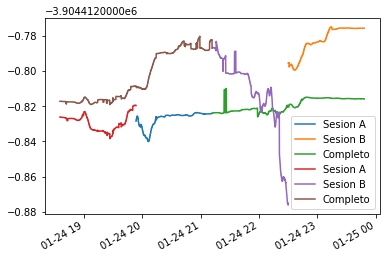

In [29]:
fig,ax = plt.subplots()
(sessA.latitude * DEG2RAD * 6.4e6).iloc[len(sessA)//2:].plot(label='Sesion A',ax=ax)
(sessB.latitude * DEG2RAD * 6.4e6).iloc[len(sessB)//2:].plot(label='Sesion B',ax=ax)
(sessC.latitude * DEG2RAD * 6.4e6).iloc[len(sessC)//2:].plot(label='Completo',ax=ax)
(sessAb.latitude * DEG2RAD * 6.4e6).iloc[len(sessAb)//2:].plot(label='Sesion A',ax=ax)
(sessBb.latitude * DEG2RAD * 6.4e6).iloc[len(sessBb)//2:].plot(label='Sesion B',ax=ax)
(sessCb.latitude * DEG2RAD * 6.4e6).iloc[len(sessCb)//2:].plot(label='Completo',ax=ax)

print('sessionA:{},sessionB:{},sessionC:{}'.format(*[i.latitude.median() for i in (sessA,sessB,sessC)]))
ax.legend()
plt.show()

In [30]:
print(sessA.index[0],sessA.index[-1])
print(sessB.index[0],sessB.index[-1])
print(sessC.index[0],sessC.index[-1])
print(sessAb.index[0],sessAb.index[-1])
print(sessBb.index[0],sessBb.index[-1])
print(sessCb.index[0],sessCb.index[-1])

2020-01-24 18:35:15 2020-01-24 21:11:45
2020-01-24 21:11:45 2020-01-24 23:48:15
2020-01-24 18:35:15 2020-01-24 23:48:15
2020-01-24 21:11:45 2020-01-24 18:35:15
2020-01-24 23:48:15 2020-01-24 21:11:45
2020-01-24 23:48:15 2020-01-24 18:35:15


sessionA:-58.792189722,sessionB:-58.79218925,sessionC:-58.792189706


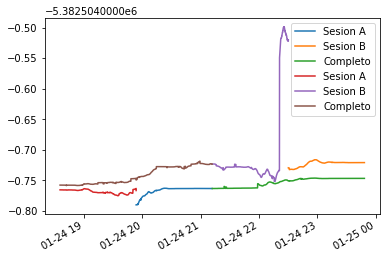

In [31]:
reflat = sessA.latitude.median()
cosreflat = cos(reflat * DEG2RAD)

fig,ax = plt.subplots()

(sessA.longitude * DEG2RAD * cosreflat * 6.4e6).iloc[len(sessA)//2:].plot(label='Sesion A',ax=ax)
(sessB.longitude * DEG2RAD * cosreflat * 6.4e6).iloc[len(sessB)//2:].plot(label='Sesion B',ax=ax)
(sessC.longitude * DEG2RAD * cosreflat * 6.4e6).iloc[len(sessC)//2:].plot(label='Completo',ax=ax)
(sessAb.longitude * DEG2RAD * cosreflat * 6.4e6).iloc[len(sessAb)//2:].plot(label='Sesion A',ax=ax)
(sessBb.longitude * DEG2RAD * cosreflat * 6.4e6).iloc[len(sessBb)//2:].plot(label='Sesion B',ax=ax)
(sessCb.longitude * DEG2RAD * cosreflat * 6.4e6).iloc[len(sessCb)//2:].plot(label='Completo',ax=ax)



print('sessionA:{},sessionB:{},sessionC:{}'.format(*[i.longitude.median() for i in (sessA,sessB,sessC)]))

ax.legend()
plt.show()

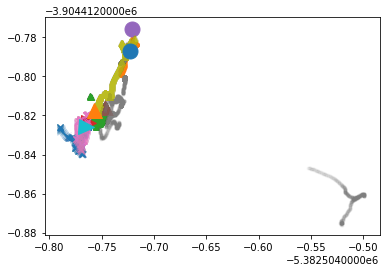

In [32]:
plt.subplots()

plt.plot(sessA.iloc[len(sessA)//2:].longitude * DEG2RAD * cosreflat * 6.4e6,sessA.iloc[len(sessA)//2:].latitude * DEG2RAD * 6.4e6,'x',alpha=0.05)
plt.plot(sessB.iloc[len(sessB)//2:].longitude * DEG2RAD * cosreflat * 6.4e6,sessB.iloc[len(sessB)//2:].latitude * DEG2RAD * 6.4e6,'.',alpha=0.05)
plt.plot(sessC.iloc[len(sessC)//2:].longitude * DEG2RAD * cosreflat * 6.4e6,sessC.iloc[len(sessC)//2:].latitude * DEG2RAD * 6.4e6,'^',alpha=0.05)

plt.plot(sessA.longitude[-1] * DEG2RAD * cosreflat * 6.4e6,sessA.latitude[-1] * DEG2RAD * 6.4e6,'>',markersize=15)
plt.plot(sessB.longitude[-1] * DEG2RAD * cosreflat * 6.4e6,sessB.latitude[-1] * DEG2RAD * 6.4e6,'o',markersize=15)
plt.plot(sessC.longitude[-1] * DEG2RAD * cosreflat * 6.4e6,sessC.latitude[-1] * DEG2RAD * 6.4e6,'^',markersize=15)

plt.plot(sessAb.iloc[len(sessAb)//2:].longitude * DEG2RAD * cosreflat * 6.4e6,sessAb.iloc[len(sessAb)//2:].latitude * DEG2RAD * 6.4e6,'x',alpha=0.05)
plt.plot(sessBb.iloc[len(sessBb)//2:].longitude * DEG2RAD * cosreflat * 6.4e6,sessBb.iloc[len(sessBb)//2:].latitude * DEG2RAD * 6.4e6,'.',alpha=0.05)
plt.plot(sessCb.iloc[len(sessCb)//2:].longitude * DEG2RAD * cosreflat * 6.4e6,sessCb.iloc[len(sessCb)//2:].latitude * DEG2RAD * 6.4e6,'^',alpha=0.05)

plt.plot(sessAb.longitude[-1] * DEG2RAD * cosreflat * 6.4e6,sessAb.latitude[-1] * DEG2RAD * 6.4e6,'>',markersize=15)
plt.plot(sessBb.longitude[-1] * DEG2RAD * cosreflat * 6.4e6,sessBb.latitude[-1] * DEG2RAD * 6.4e6,'o',markersize=15)
plt.plot(sessCb.longitude[-1] * DEG2RAD * cosreflat * 6.4e6,sessCb.latitude[-1] * DEG2RAD * 6.4e6,'^',markersize=15)

plt.show()

sessionA:36.2483,sessionB:36.2989,sessionC:36.2563


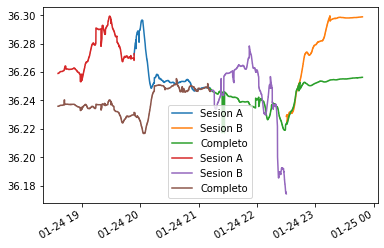

In [33]:
fig,ax = plt.subplots()

sessA.iloc[len(sessA)//2:].height.plot(label='Sesion A',ax=ax)
sessB.iloc[len(sessB)//2:].height.plot(label='Sesion B',ax=ax)
sessC.iloc[len(sessC)//2:].height.plot(label='Completo',ax=ax)
sessAb.iloc[len(sessAb)//2:].height.plot(label='Sesion A',ax=ax)
sessBb.iloc[len(sessBb)//2:].height.plot(label='Sesion B',ax=ax)
sessCb.iloc[len(sessCb)//2:].height.plot(label='Completo',ax=ax)

print('sessionA:{},sessionB:{},sessionC:{}'.format(*[i.height[-1] for i in (sessA,sessB,sessC)]))

ax.legend()

plt.show()

In [34]:
PFD1_A = pd.Series({'latitud':sessA.latitude[-1],'longitud':sessA.longitude[-1],'altura':sessA.height[-1]})
PFD1_B = pd.Series({'latitud':sessB.latitude[-1],'longitud':sessB.longitude[-1],'altura':sessB.height[-1]})
PFD1_C = pd.Series({'latitud':sessC.latitude[-1],'longitud':sessC.longitude[-1],'altura':sessC.height[-1]})

In [35]:
sesiones_string = \
"""
{latitud} {longitud} {altura}""".format(**PFD1_A) +\
"""
{latitud} {longitud} {altura}""".format(**PFD1_B) +\
"""
{latitud} {longitud} {altura}""".format(**PFD1_C) +\
"""
EOF
"""

!proj -f %.3f +proj=tmerc +ellps=GRS80 +lat_0=-90 +lon_0=-60 +x_0=5500000 +no_defs << EOF $sesiones_string

6925680.704	3209257.563 36.2483
6925680.747	3209257.603 36.2989
6925680.715	3209257.581 36.2563


In [36]:
PFD1_Ab = pd.Series({'latitud':sessAb.latitude[-1],'longitud':sessAb.longitude[-1],'altura':sessAb.height[-1]})
PFD1_Bb = pd.Series({'latitud':sessBb.latitude[-1],'longitud':sessBb.longitude[-1],'altura':sessBb.height[-1]})
PFD1_Cb = pd.Series({'latitud':sessCb.latitude[-1],'longitud':sessCb.longitude[-1],'altura':sessCb.height[-1]})

In [37]:
sesiones_string = \
"""
{latitud} {longitud} {altura}""".format(**PFD1_Ab) +\
"""
{latitud} {longitud} {altura}""".format(**PFD1_Bb) +\
"""
{latitud} {longitud} {altura}""".format(**PFD1_Cb) +\
"""
EOF
"""

!proj -f %.3f +proj=tmerc +ellps=GRS80 +lat_0=-90 +lon_0=-60 +x_0=5500000 +no_defs << EOF $sesiones_string

6925680.702	3209257.561 36.259
6925680.740	3209257.602 36.2468
6925680.710	3209257.568 36.2359


In [38]:
print('{latitud:13.9f} {longitud:14.9f} {altura:9.3f}  PFD1  PFD1'.format(**PFD1_C))

-34.954150747  -58.792189530    36.256  PFD1  PFD1


In [39]:
with open('/rtklib/data/ramsac.pos','a+') as f:
    print('{latitud:13.9f} {longitud:14.9f} {altura:9.3f}  PFD1  PFD1'.format(**PFD1_C),file=f)

# Vector de Orientación

In [40]:
try:
    with open('/proyecto/conf2.cfg','r') as f:
        confs = {i.strip():j.strip() for i,j in [k.split('=') for k in f.readlines()]}

        for i in pyconf.formulario.children:
            try:
                if i.description == 'pos1-navsys':
                    continue

                opts = [j.split(':')[1] for j in i.options]
                optsn = [j.split(':')[0] for j in i.options]

                if (val := confs[i.description]) in opts:
                    i.value = i.options[opts.index(val)]
                elif (val := confs[i.description]) in optsn:
                    i.value = i.options[optsn.index(val)]
            except AttributeError:
                if isinstance(i.value,int):
                    if confs[i.description] == '':
                        i.value = -1
                    else:
                        i.value = int(confs[i.description])
                elif isinstance(i.value,str):
                    i.value = confs[i.description]
                elif isinstance(i.value,float):
                    i.value = float(confs[i.description])
                    if confs[i.description] == '':
                        i.value = -1
except FileNotFoundError:
    pass

In [41]:
pyconf.formulario

GridspecLayout(children=(Dropdown(description='pos1-posmode', index=3, layout=Layout(grid_area='widget001'), o…

In [42]:
import numbers

with open('/proyecto/conf2.cfg','w') as f:
    for i in pyconf.formulario.children:
        try:
            if isinstance(i.value, (list, tuple)):
                value = sum([int(v.split(':')[0]) for v in i.value if v.split(':')[0] != ''])
            else:
                value = i.value.split(':')[-1]
                
            try:
                if int(value) < 0: # -1 is blank
                    value = ''
            except ValueError:
                pass
            
        except AttributeError:
            value = i.value
            try:
                if int(value) < 0: # -1 is blank
                    value = ''
            except ValueError:
                pass

        print('{} ={}'.format(i.description,value),file=f)

In [43]:
rinex_info2 = !RinSum /proyecto/PFD20240.20o
print('\n'.join(rinex_info2))

# RinSum, part of the GPS Toolkit, Ver 4.1 8/26/15, Run 2021/03/29 23:05:50
+++++++++++++ RinSum summary of Rinex obs file /proyecto/PFD20240.20o +++++++++++++
---------------------------------- REQUIRED ----------------------------------
Rinex Version  2.11,  File type O,  System G (GPS).
Prgm: JJC Open Gps Read,  Run: 22 - OCT - 20 21:16,  By: Javier Clavijo
Marker name: PFD2, Marker type: .
Observer : Raul Clavijo,  Agency: RyJClavijo
Rec#: 3E302069,  Type: PromarkXCM,  Vers: 
Antenna # : 200721052,  Type : NAP100
Position      (XYZ,m) : (0.0000, 0.0000, 0.0000).
Antenna Delta (HEN,m) : (1.4990, 0.0000, 0.0000).
GPS Observation types (3):
 Type #01 (L1C) L1 GPSC/A phase
 Type #02 (C1C) L1 GPSC/A pseudorange
 Type #03 (D1C) L1 GPSC/A doppler
R2ObsTypes: L1 C1 D1 
mapSysR2toR3ObsID[G] C1:C1C D1:D1C L1:L1C 
Time of first obs 2020/01/24 19:37:31.000 GPS
(This header is VALID)
---------------------------------- OPTIONAL ----------------------------------
Signal Strenth Unit = 
Interval =

In [44]:
for i in rinex_info2:
    if m := re.match(r'.*first\s+epoch:\s+(\d+).(\d+).(\d+).*?(\d+).(\d+).(\d+).*',i):
        ini_time2 = totime((int(i) for i in m.groups()))
        print('Epoca inicial: ',m.groups())
    if m := re.match(r'.*last\s+epoch:\s+(\d+).(\d+).(\d+).*?(\d+).(\d+).(\d+).*',i):
        end_time2 = totime((int(i) for i in m.groups()))
        print('Epoca final: ',m.groups())

Epoca inicial:  ('2020', '01', '24', '19', '37', '31')
Epoca final:  ('2020', '01', '25', '00', '21', '47')


In [59]:
punto = '{}/splits/{}'.format(FILEFLD,splitfiles[4][1])
base = '{}/{}'.format(FILEFLD,splitfiles[2][0])
#nav = '{}/{}'.format(FILEFLD,splitfiles[0][0])[:-1] + 'n'
#eph = '{} {} {}'.format(*set(sp3files))

In [60]:
!echo rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2A.txt
!rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2A.txt

!echo rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2A-b.txt
!rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2A-b.txt

rnx2rtkp -k proyecto/conf2.cfg proyecto/splits/PFD20241.20o proyecto/PFD10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o Sesion2A.txt
rnx2rtkp -b -k proyecto/conf2.cfg proyecto/splits/PFD20241.20o proyecto/PFD10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o Sesion2A-b.txt


In [61]:
punto = '{}/splits/{}'.format(FILEFLD,splitfiles[5][1])

In [62]:
!echo rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2B.txt
!rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2B.txt

!echo rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2B-b.txt
!rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2B-b.txt

rnx2rtkp -k proyecto/conf2.cfg proyecto/splits/PFD20242.20o proyecto/PFD10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o Sesion2B.txt
rnx2rtkp -b -k proyecto/conf2.cfg proyecto/splits/PFD20242.20o proyecto/PFD10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o Sesion2B-b.txt


In [63]:
punto = '{}/{}'.format(FILEFLD,splitfiles[4][0])

In [64]:
!echo rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2C.txt
!rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2C.txt

!echo rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2C-b.txt
!rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2C-b.txt

rnx2rtkp -k proyecto/conf2.cfg proyecto/PFD20240.20o proyecto/PFD10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o Sesion2C.txt
rnx2rtkp -b -k proyecto/conf2.cfg proyecto/PFD20240.20o proyecto/PFD10240.20o proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20894.sp3 sp3/igs20895.sp3 -o Sesion2C-b.txt


In [65]:
sess2A = pd.read_fwf('Sesion2A.txt',comment='%',names=cols,index=None)
sess2A = sess2A.set_index((sess2A.date + 'T' + sess2A.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))
sess2B = pd.read_fwf('Sesion2B.txt',comment='%',names=cols,index=None)
sess2B = sess2B.set_index((sess2B.date + 'T' + sess2B.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))
sess2C = pd.read_fwf('Sesion2C.txt',comment='%',names=cols,index=None)
sess2C = sess2C.set_index((sess2C.date + 'T' + sess2C.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))

session2A:-34.945944638,session2B:-34.945944602,session2C:-34.945944629


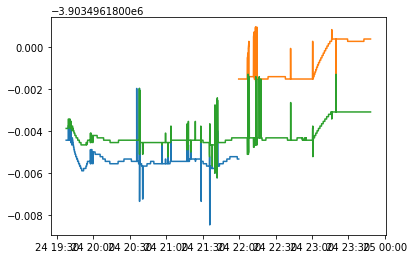

In [66]:
fig,ax = plt.subplots()
ax.plot(sess2A.index,(sess2A.latitude * DEG2RAD * 6.4e6).values)
ax.plot(sess2B.index,(sess2B.latitude * DEG2RAD * 6.4e6).values)
ax.plot(sess2C.index,(sess2C.latitude * DEG2RAD * 6.4e6).values)

print('session2A:{},session2B:{},session2C:{}'.format(*[i.latitude.median() for i in (sess2A,sess2B,sess2C)]))

plt.show()

session2A:-58.782975801,session2B:-58.782975755,session2C:-58.782975786


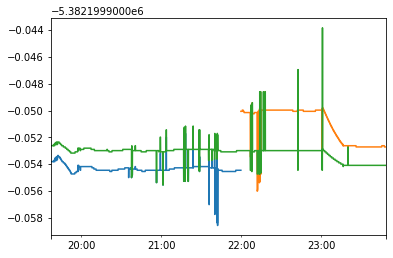

In [67]:
reflat = sess2A.latitude.median()
cosreflat = cos(reflat * DEG2RAD)

(sess2A.longitude * DEG2RAD * cosreflat * 6.4e6).plot()
(sess2B.longitude * DEG2RAD * cosreflat * 6.4e6).plot()
(sess2C.longitude * DEG2RAD * cosreflat * 6.4e6).plot()

print('session2A:{},session2B:{},session2C:{}'.format(*[i.longitude.median() for i in (sess2A,sess2B,sess2C)]))

plt.show()

session2A:40.2526,session2B:40.2388,session2C:40.2461


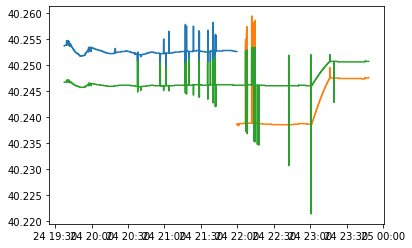

In [68]:
fig,ax = plt.subplots()
ax.plot(sess2A.index,(sess2A.height).values)
ax.plot(sess2B.index,(sess2B.height).values)
ax.plot(sess2C.index,(sess2C.height).values)

print('session2A:{},session2B:{},session2C:{}'.format(*[i.height.median() for i in (sess2A,sess2B,sess2C)]))

plt.show()

In [69]:
PFD2_A = pd.Series({'latitud':sess2A.latitude[-1],'longitud':sess2A.longitude[-1],'altura':sess2A.height[-1]})
PFD2_B = pd.Series({'latitud':sess2B.latitude[-1],'longitud':sess2B.longitude[-1],'altura':sess2B.height[-1]})
PFD2_C = pd.Series({'latitud':sess2C.latitude[-1],'longitud':sess2C.longitude[-1],'altura':sess2C.height[-1]})

In [71]:
sesiones_string = \
"""
{longitud} {latitud} {altura}""".format(**PFD2_A) +\
"""
{longitud} {latitud} {altura}""".format(**PFD2_B) +\
"""
{longitud} {latitud} {altura}""".format(**PFD2_C) +\
"""
EOF
"""

!proj -f %.3f +proj=tmerc +ellps=GRS80 +lat_0=-90 +lon_0=-60 +x_0=5500000 +no_defs << EOF $sesiones_string

5611175.824	6132693.338 40.2526
5611175.826	6132693.343 40.2476
5611175.824	6132693.340 40.2507


In [57]:
print('{latitud:13.9f} {longitud:14.9f} {altura:9.3f}'.format(**PFD2_A))

-34.945944632  -58.782975814    40.250


# Antenas:

https://www.ngs.noaa.gov/ANTCAL/LoadFile?file=ASH110454_NONE.atx

https://kb.igs.org/hc/en-us/articles/216104678-ANTEX-format-description


```      
                                                            START OF ANTENNA    
NAP100          NONE                                        TYPE / SERIAL NO    
FIELD               JJC                      0    02-DIC-20 METH / BY / # / DATE
     0.0                                                    DAZI                
     0.0  80.0   5.0                                        ZEN1 / ZEN2 / DZEN  
     1                                                      # OF FREQUENCIES    
CONVERTED FROM RELATIVE NGS ANTENNA CALIBRATIONS            COMMENT             
   G01                                                      START OF FREQUENCY  
      0.00      0.00     73.00                              NORTH / EAST / UP   
   G01                                                      END OF FREQUENCY    
                                                            END OF ANTENNA      
```      
                                                            

